In [8]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model
import json


In [9]:
#Parameters to change, can change model_type to 'best' or 'last'
#modelname = 'MultiBody8-Subjettiness_massTrue_ptTrue_best_baseline'
modelname = 'MultiBody8-Subjettiness_massTrue_ptTrue_best_tau_x_1'
model_dict = json.load(open('../../models/Multi-Body/trained_model_dicts/' + modelname.replace("_best", "") + ".json"))
use_jet_pt = model_dict['use_pt']
use_jet_mass = model_dict['use_mass']
tau_x_1 = model_dict['tau_x_1']
N = model_dict['N']
extra_name = model_dict['label']
hidden = list(map(int, model_dict['nodes'].split(',')))


model_type = 'best'
if extra_name != '' and not extra_name.startswith('_'):
    extra_name = '_' + extra_name
if tau_x_1 and 'tau_x_1' not in extra_name:
    extra_name += '_tau_x_1'


#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/trained_models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+\
             '_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1, hidden).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()
model_layers = [layer for layer in model._nn]

In [10]:
#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
feat_names = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            feat_names.append('tau_'+str(i+1)+'_'+str(0.5))
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
        else:
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
else:
    for i in range(N-1):
        feat_names.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(feat_names, ['background_prob', 'signal_prob']))
feats = df_test.drop(columns=['background_prob', 'signal_prob'])
means = np.array(df_test.mean(0))


In [11]:
bkg_indices = labels[:,0] == 1
sig_indices = labels[:,1] == 1

In [12]:
tau21 = df_test['tau_2_1']/df_test['tau_1_1']
tau32 = df_test['tau_3_1']/df_test['tau_2_1']

df_tauratio_bkg = pd.DataFrame({'tau21':tau21[bkg_indices],
                                'tau32':tau32[bkg_indices]})
df_tauratio_bkg = df_tauratio_bkg.reset_index(drop=True)

df_tauratio_sig = pd.DataFrame({'tau21':tau21[sig_indices],
                                'tau32':tau32[sig_indices]})
df_tauratio_sig = df_tauratio_sig.reset_index(drop=True)
#df_tauratio_sig = pd.DataFrame(np.append(tau21[sig_indices],tau32[sig_indices],1), columns = ['tau21', 'tau32'])

In [13]:
def eval2(layers, feats):
    data = torch.tensor(np.copy(feats), dtype = torch.float32).cuda()
    hidden = []
    with torch.no_grad():
        for layer in layers:
            layer.eval()
            data = layer(data)
            hidden.append(data.cpu().numpy())
    
    return hidden

In [14]:
hidden = eval2(model_layers[:2], feats)

In [16]:
df_l1_bkg = pd.DataFrame(hidden[0][bkg_indices], columns = ['h1_{}'.format(i) for i in range(hidden[0].shape[1])])
df_l1_sig = pd.DataFrame(hidden[0][sig_indices], columns = ['h1_{}'.format(i) for i in range(hidden[0].shape[1])])

df_l2_bkg = pd.DataFrame(hidden[1][bkg_indices], columns = ['h2_{}'.format(i) for i in range(hidden[1].shape[1])])
df_l2_sig = pd.DataFrame(hidden[1][sig_indices], columns = ['h2_{}'.format(i) for i in range(hidden[1].shape[1])])


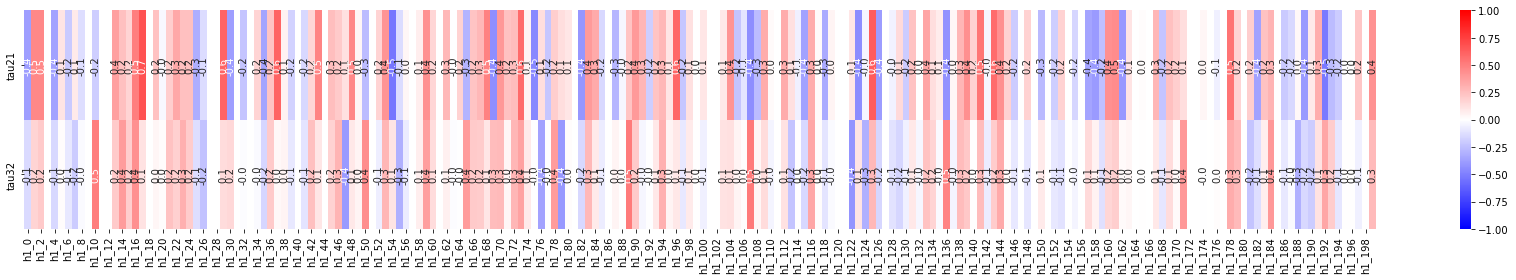

In [20]:
corrmat = pd.concat([df_l1_bkg, df_tauratio_bkg], axis=1).corr().loc[df_tauratio_bkg.columns,df_l1_bkg.columns]
plt.figure(figsize=(24,4))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.,annot_kws={'rotation': 90})
plt.tight_layout()

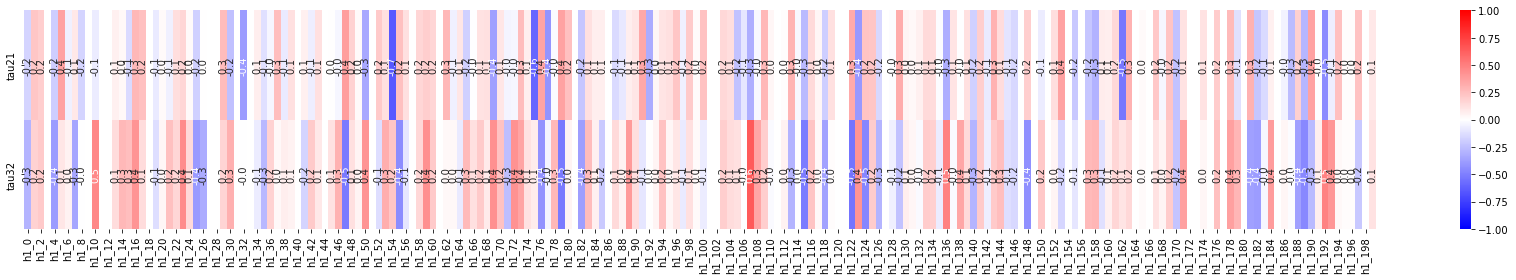

In [22]:
corrmat = pd.concat([df_l1_sig, df_tauratio_sig], axis=1).corr().loc[df_tauratio_bkg.columns,df_l1_sig.columns]
plt.figure(figsize=(24,4))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.,annot_kws={'rotation': 90})
plt.tight_layout()

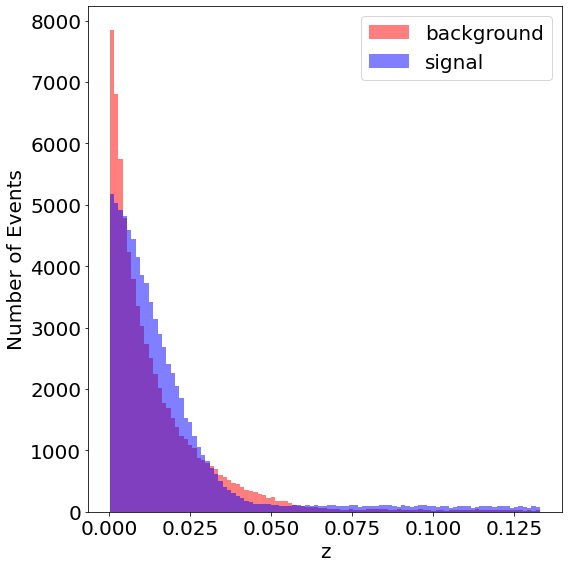

In [35]:
plt.figure(figsize=(8,8))
bkg_data = hidden[0][bkg_indices, 54]
sig_data = hidden[0][sig_indices, 54]

mr = max(np.percentile(bkg_data, 99), np.percentile(sig_data, 99))
ml = 0.0001#min(np.percentile(bkg_data, 1), np.percentile(sig_data, 1))
m = mr - ml
plt.hist(bkg_data, bins=np.arange(ml,mr,m/100), 
         label='background', color='red', alpha=0.5)
plt.hist(sig_data, bins=np.arange(ml,mr,m/100), 
         label='signal', color='blue', alpha=0.5)
plt.xlabel('z', fontsize=20)
plt.ylabel("Number of Events", fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend(fontsize = 20)
plt.tight_layout()

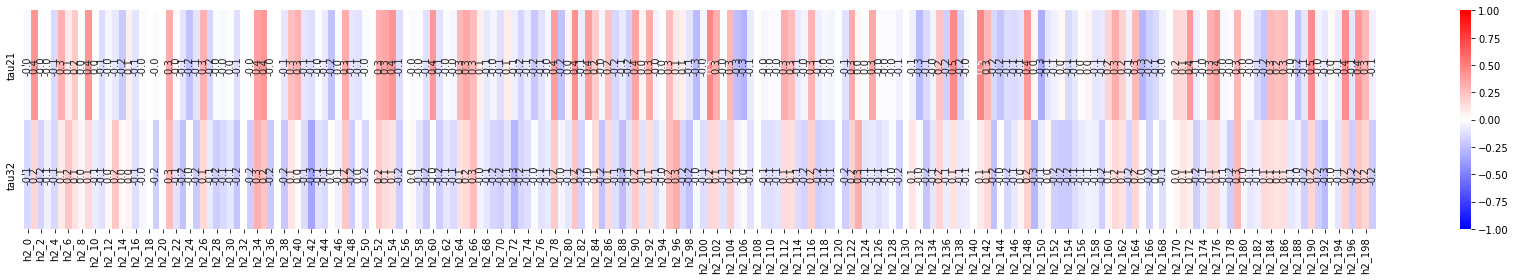

In [24]:
corrmat = pd.concat([df_l2_bkg, df_tauratio_bkg], axis=1).corr().loc[df_tauratio_bkg.columns,df_l2_bkg.columns]
plt.figure(figsize=(24,4))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.,annot_kws={'rotation': 90})
plt.tight_layout()

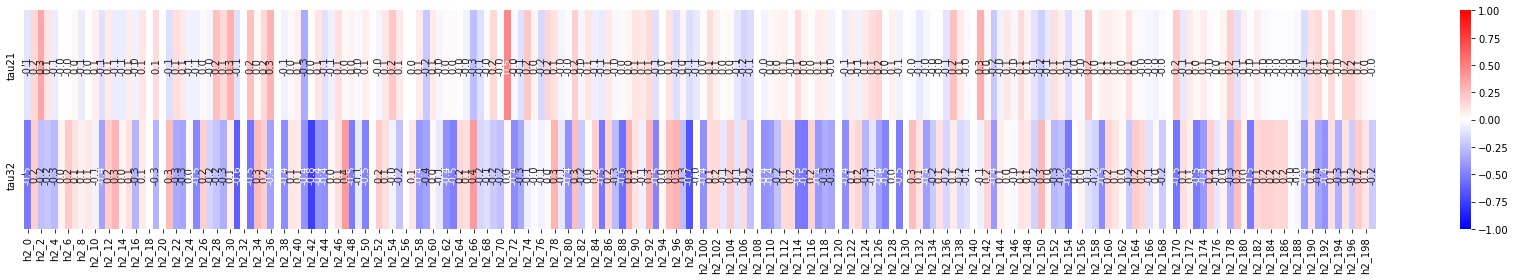

In [25]:
corrmat = pd.concat([df_l2_sig, df_tauratio_sig], axis=1).corr().loc[df_tauratio_bkg.columns,df_l2_sig.columns]
plt.figure(figsize=(24,4))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.,annot_kws={'rotation': 90})
plt.tight_layout()

In [7]:
from sklearn.decomposition import PCA

pca_l1 = PCA(n_components=0.99)
pca_l1.fit(hidden[0])

pca_l2 = PCA(n_components=0.99)
pca_l2.fit(hidden[1])

ValueError: Expected 2D array, got scalar array instead:
array=200.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [13]:
latents_pca_l1 = pca_l1.fit_transform(hidden[0])
print(latents_pca_l1.shape)

latents_pca_l2 = pca_l2.fit_transform(hidden[1])
print(latents_pca_l2.shape)

(399884, 24)
(399884, 11)


In [16]:
def PCPlotter(latents_pca):
    Nz_pca = latents_pca.shape[1]
    for ii in range(Nz_pca):
        plt.figure(figsize=(8,8))
        bkg_data = latents_pca[bkg_indices, ii]
        sig_data = latents_pca[sig_indices, ii]

        mr = max(np.percentile(bkg_data, 99), np.percentile(sig_data, 99))
        ml = min(np.percentile(bkg_data, 1), np.percentile(sig_data, 1))
        m = mr - ml
        plt.hist(bkg_data, bins=np.arange(ml,mr,m/100), label='background', color='red', alpha=0.5)
        plt.hist(sig_data, bins=np.arange(ml,mr,m/100), label='signal', color='blue', alpha=0.5)
        plt.xlabel('zpca_{}'.format(ii), fontsize=20)
        plt.ylabel("Number of Events", fontsize = 20)
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.legend(fontsize = 20)
        plt.tight_layout()

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


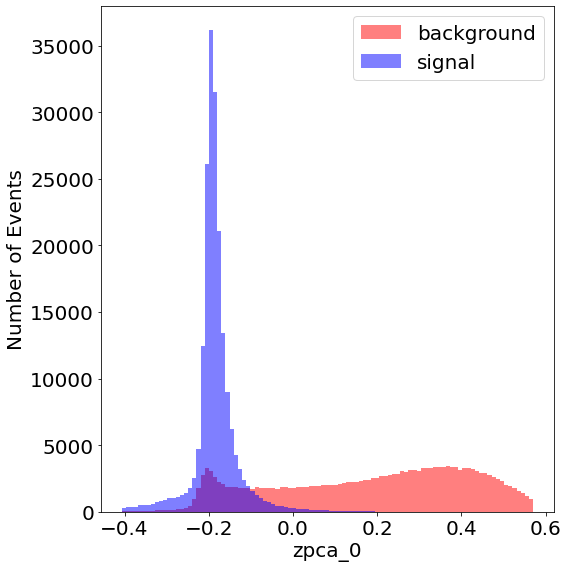

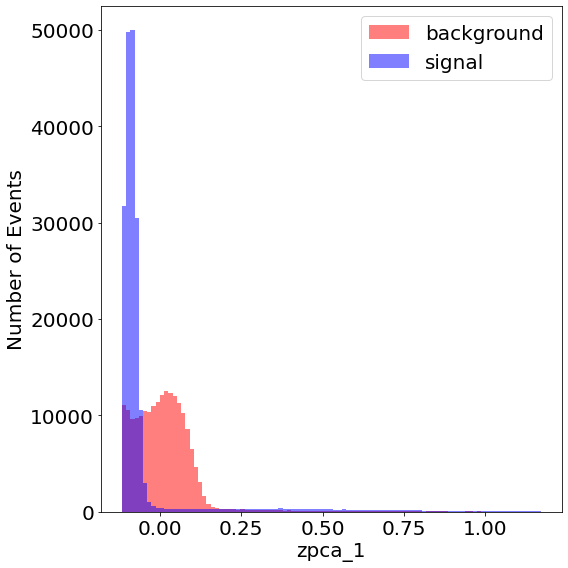

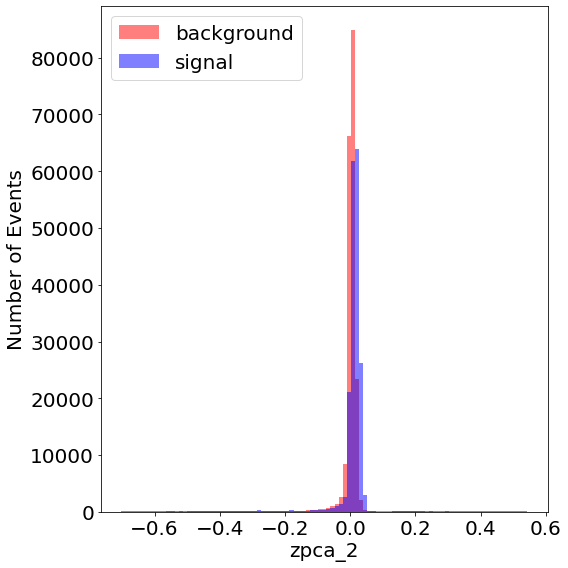

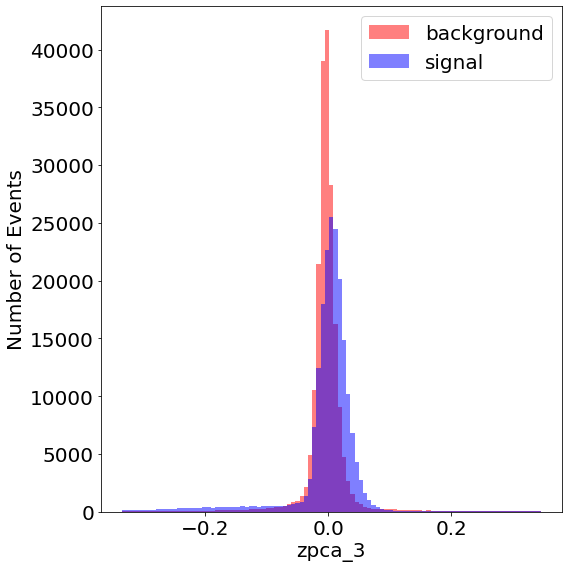

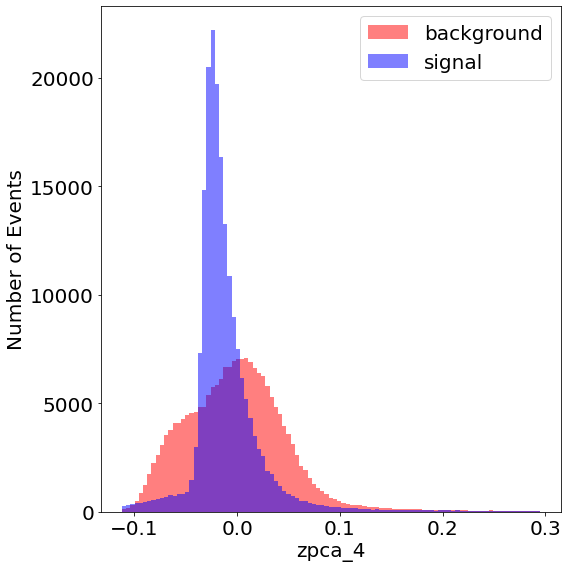

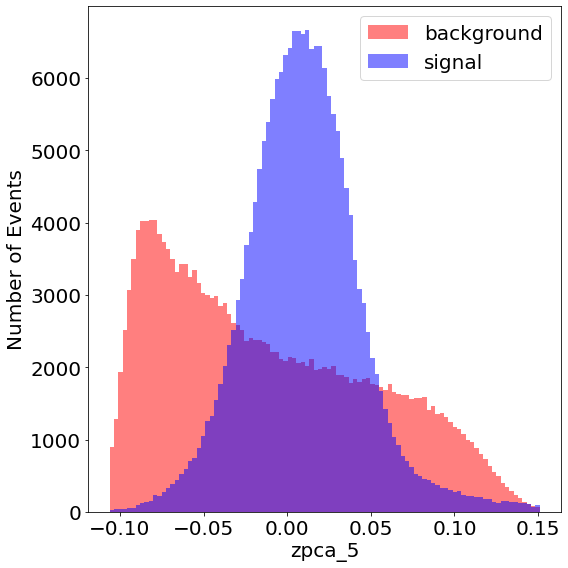

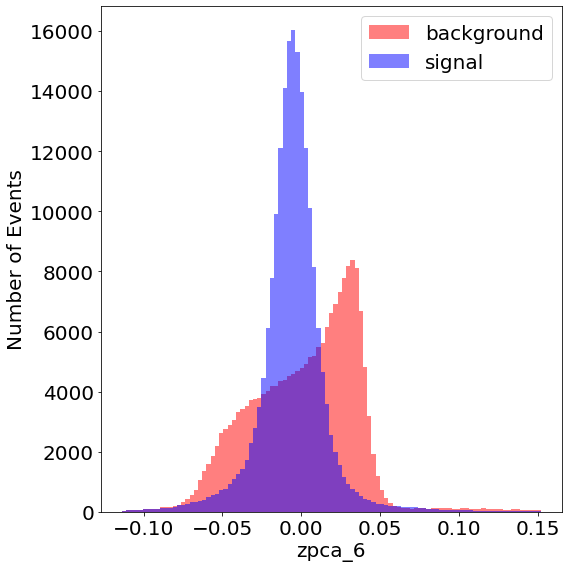

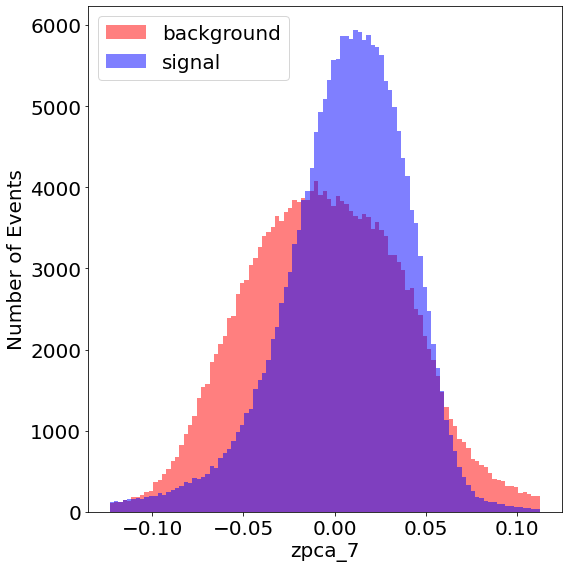

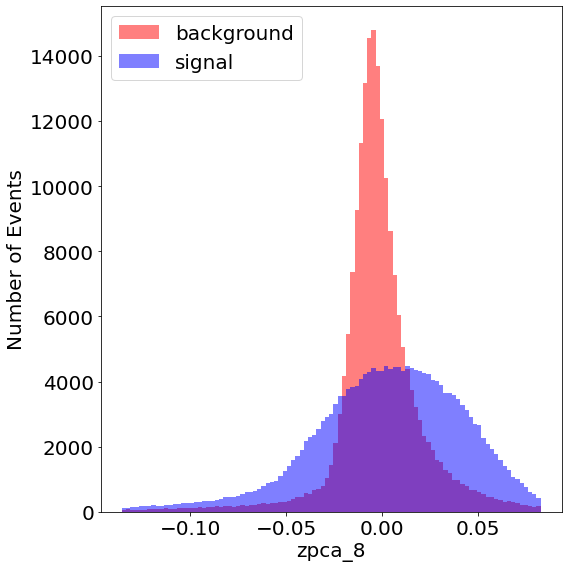

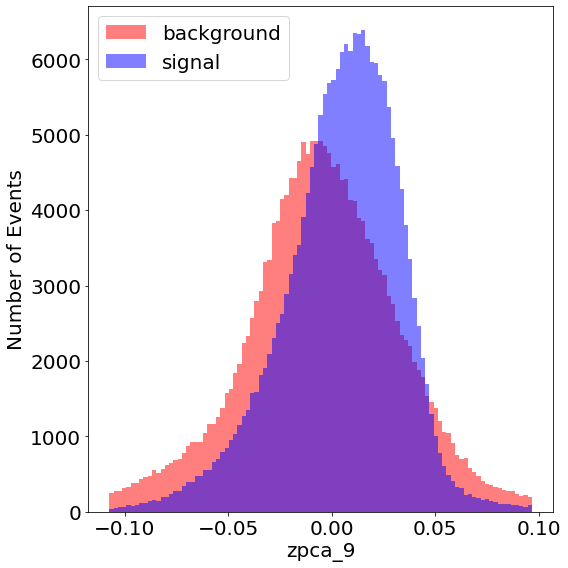

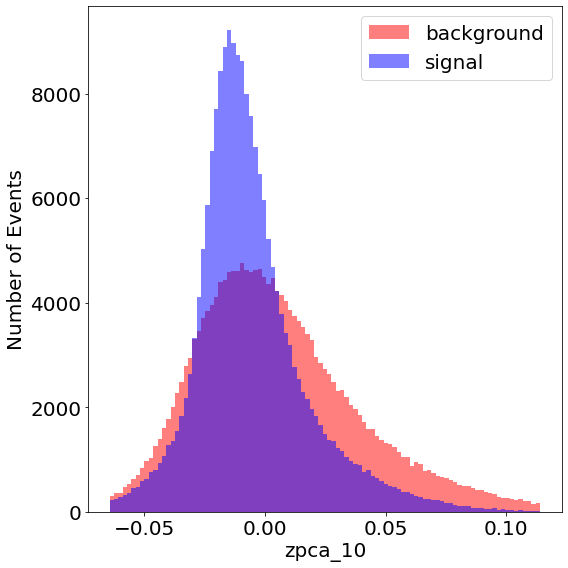

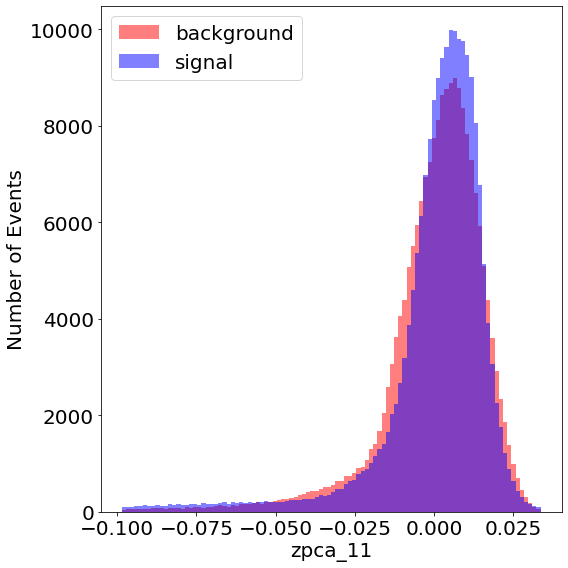

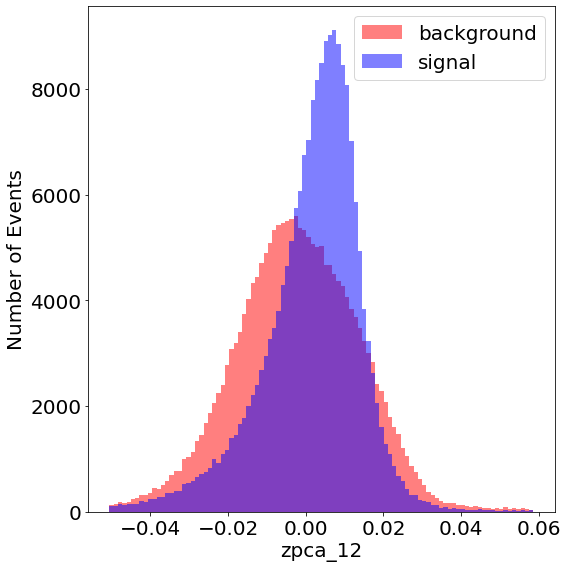

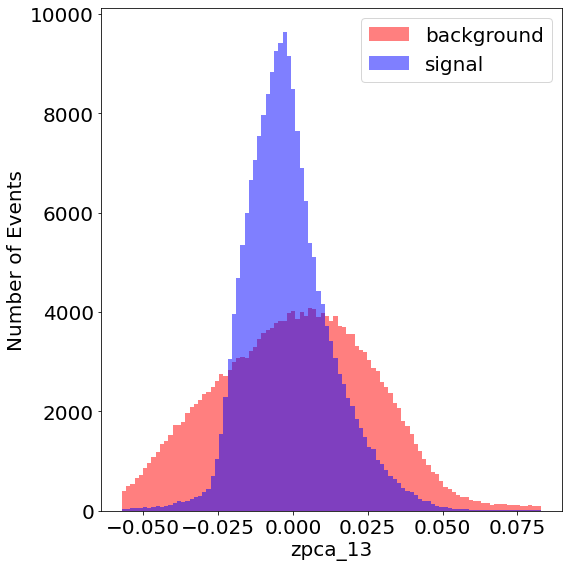

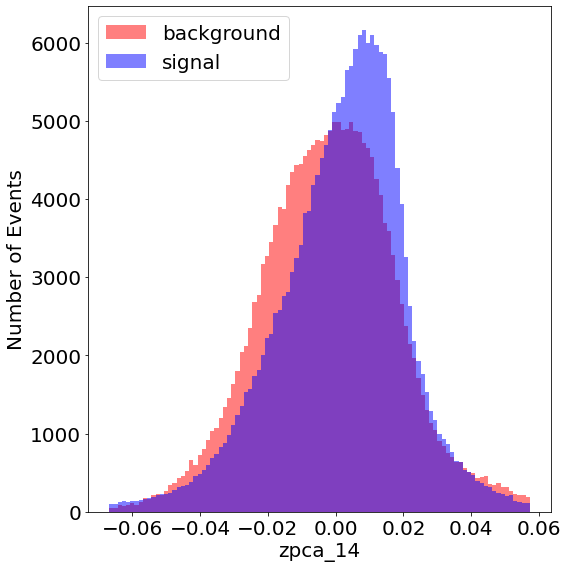

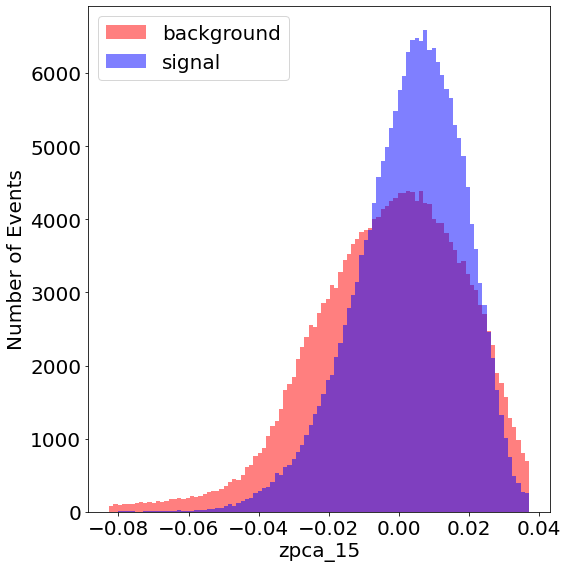

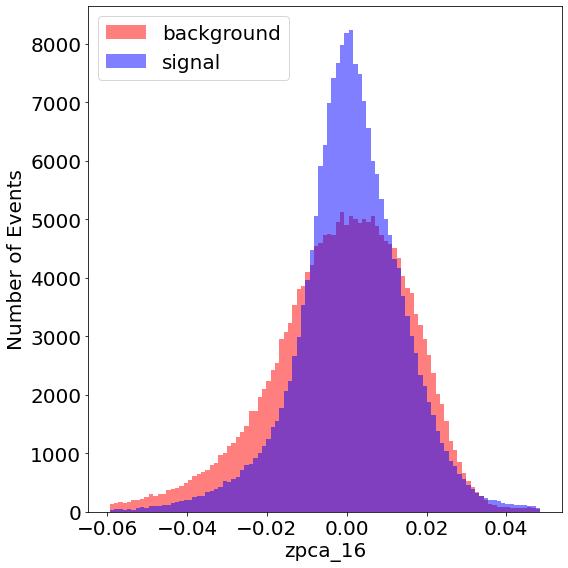

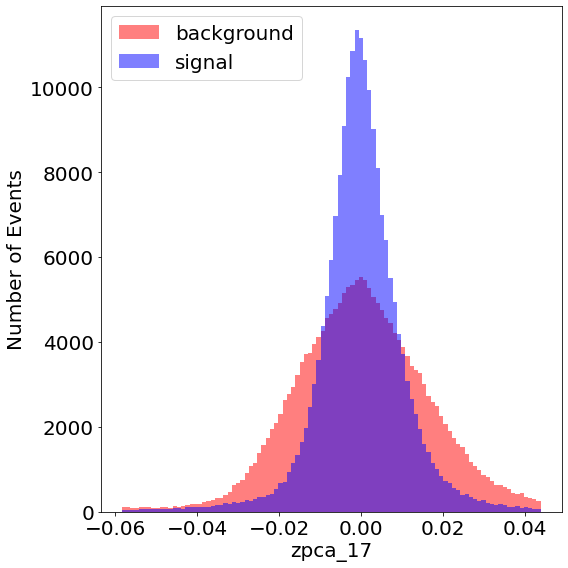

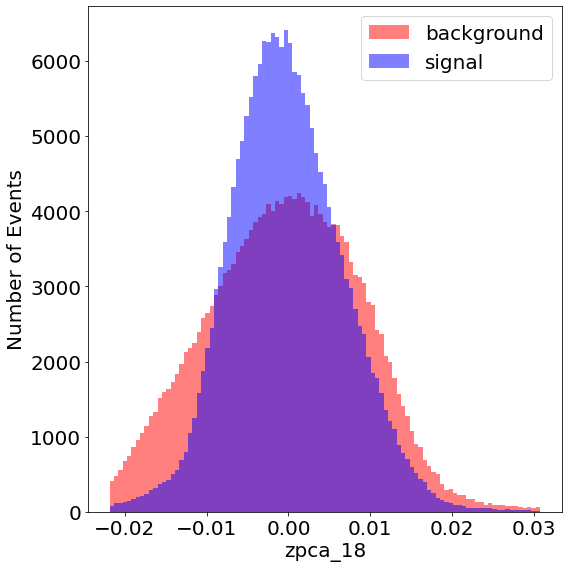

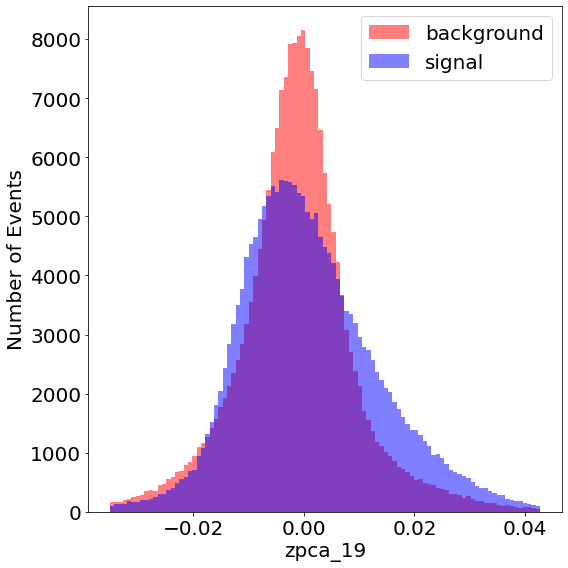

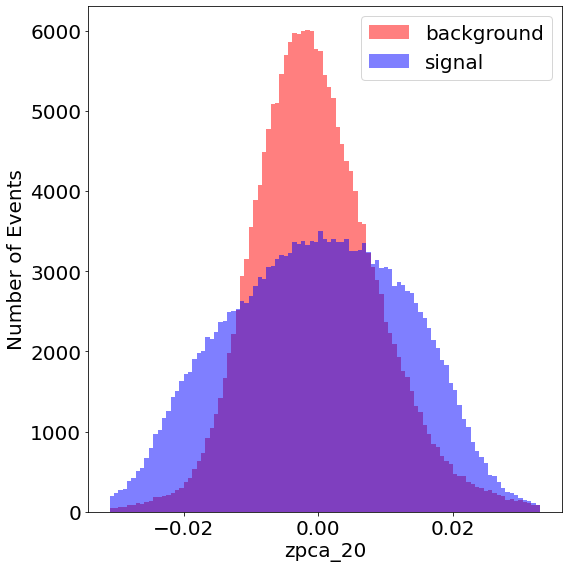

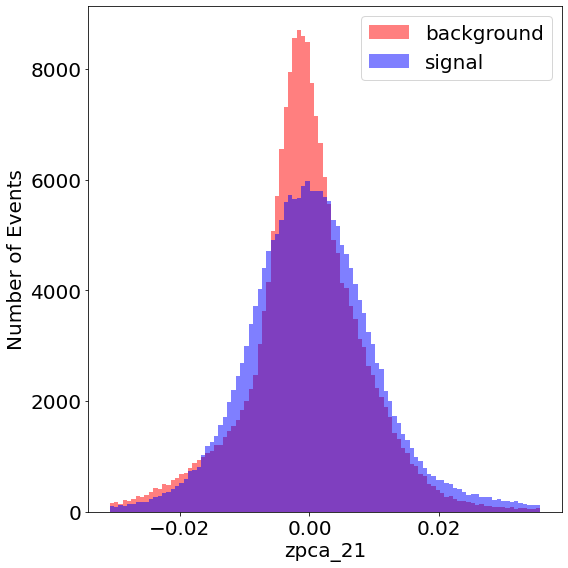

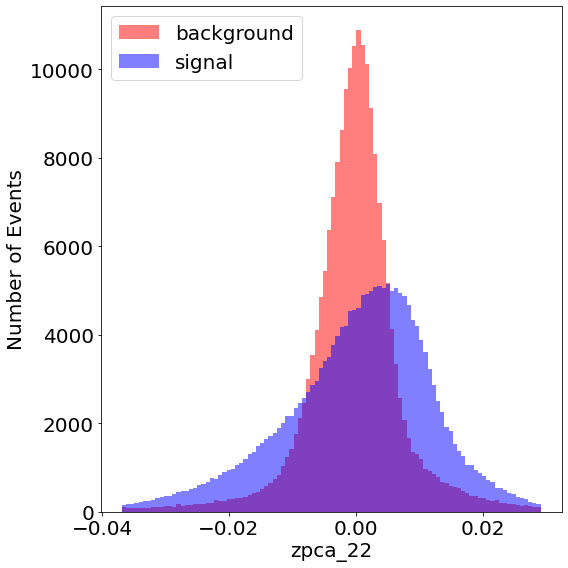

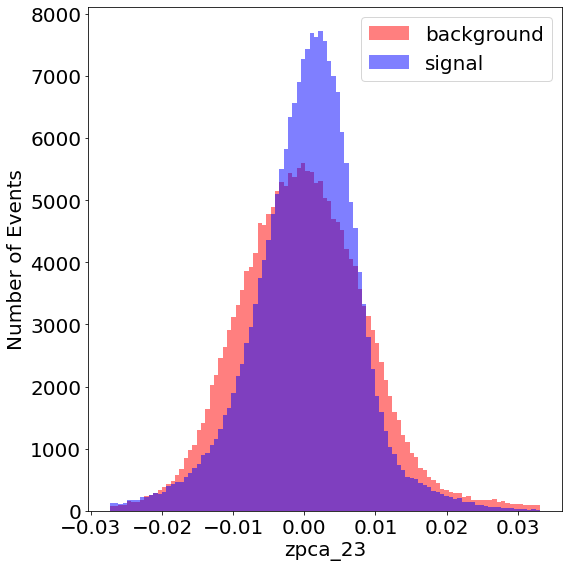

In [17]:
PCPlotter(latents_pca_l1)

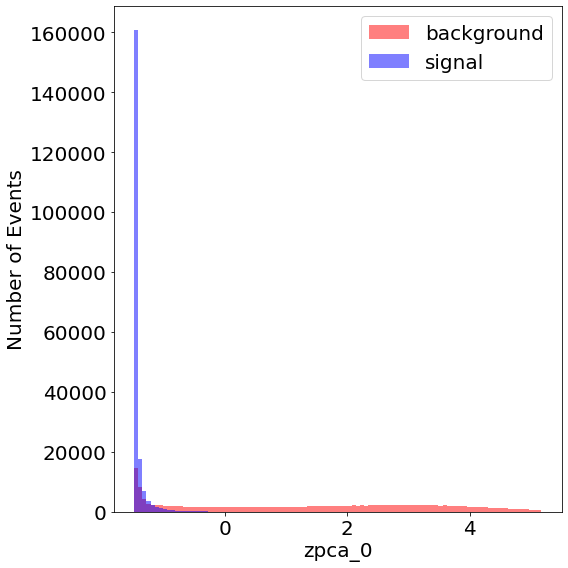

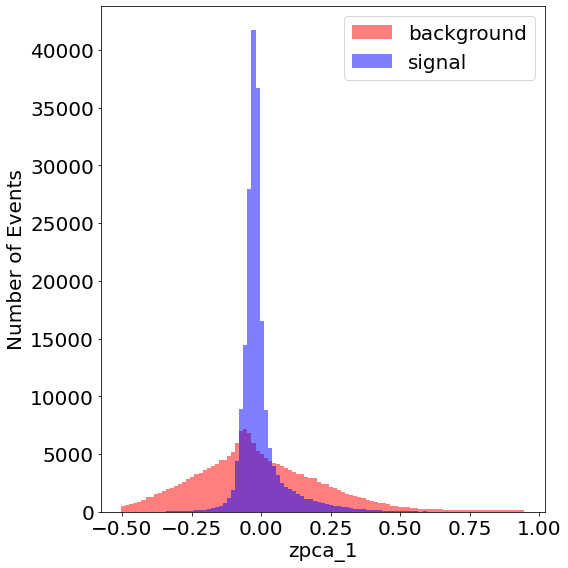

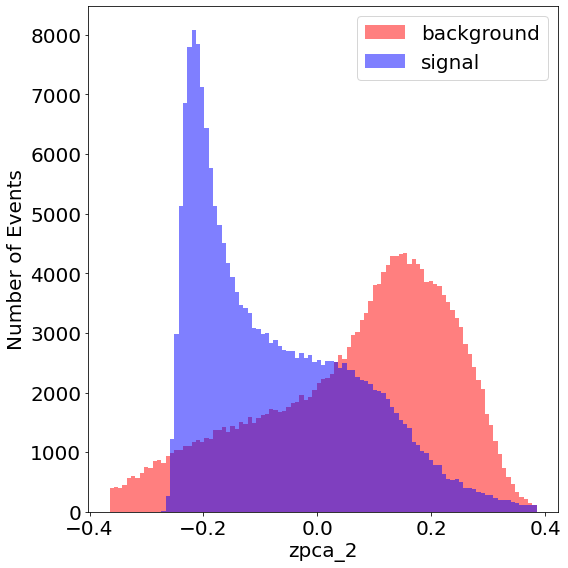

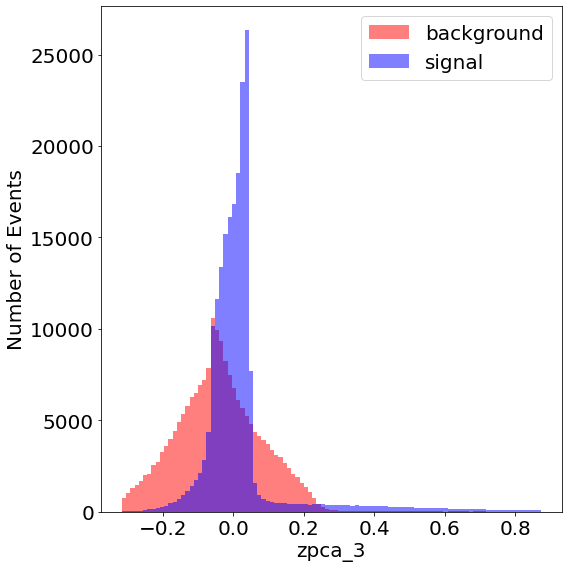

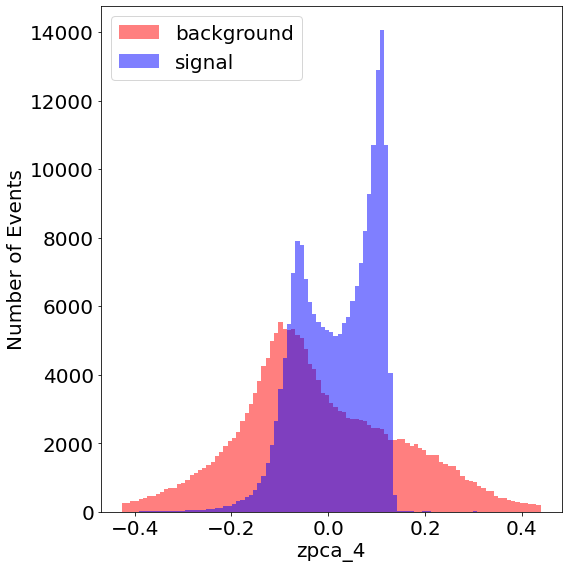

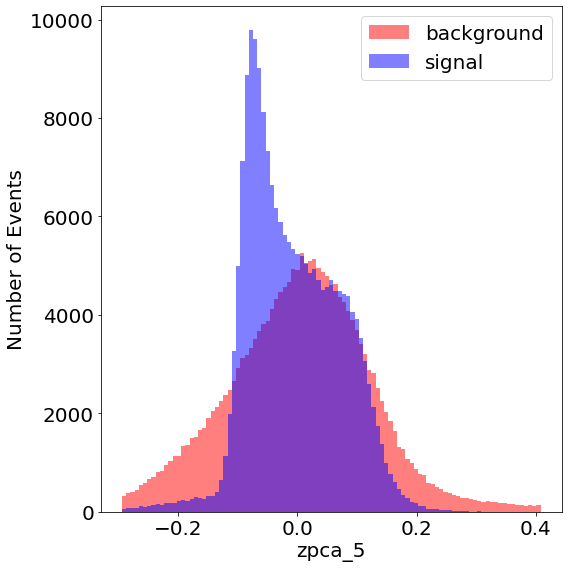

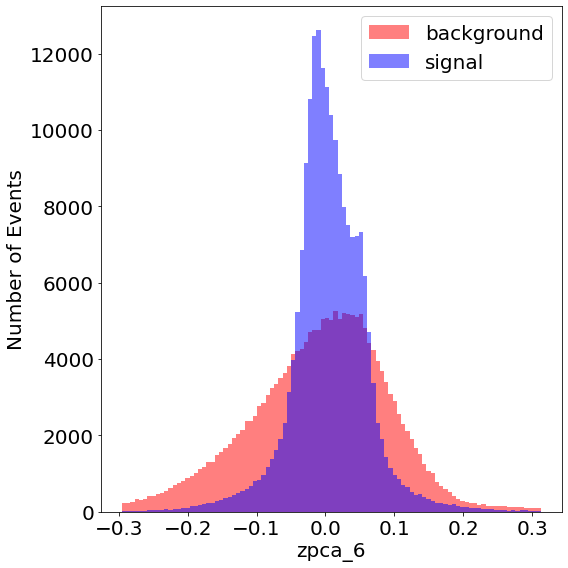

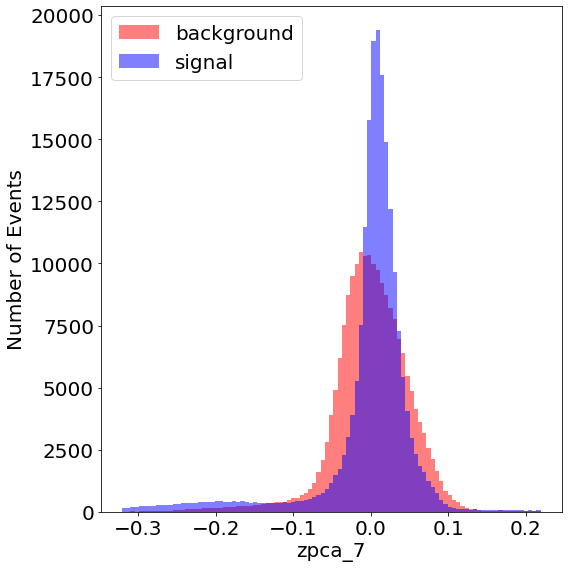

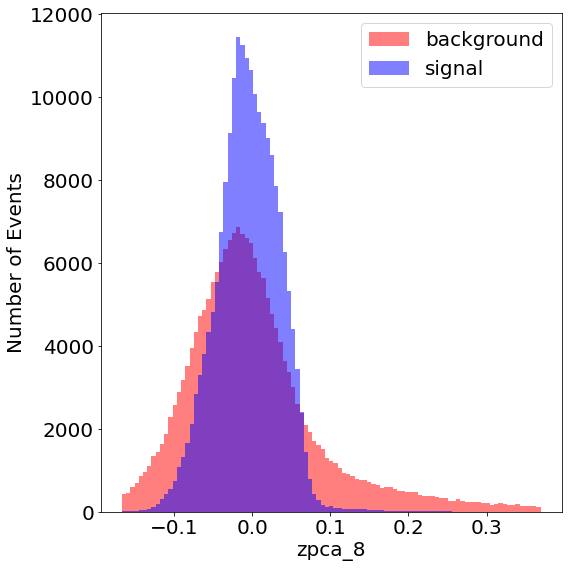

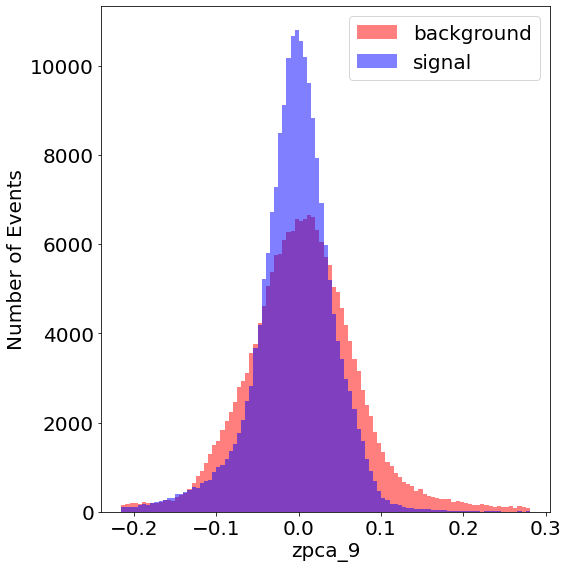

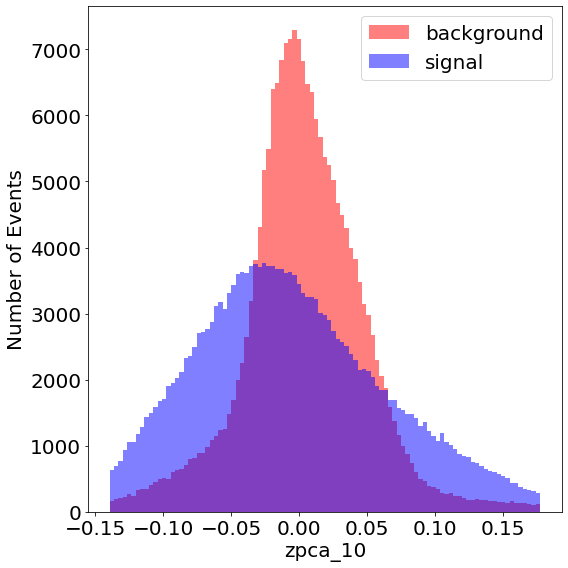

In [18]:
PCPlotter(latents_pca_l2)

In [43]:
pca_cols = ["zpca_{}".format(i) for i in range(latents_pca_l1.shape[1])]

df_pca_l1_bkg = pd.DataFrame(latents_pca_l1[bkg_indices], columns = pca_cols)
df_pca_l1_sig = pd.DataFrame(latents_pca_l1[sig_indices], columns = pca_cols)

pca_cols = ["zpca_{}".format(i) for i in range(latents_pca_l2.shape[1])]

df_pca_l2_bkg = pd.DataFrame(latents_pca_l2[bkg_indices], columns = pca_cols)
df_pca_l2_sig = pd.DataFrame(latents_pca_l2[sig_indices], columns = pca_cols)


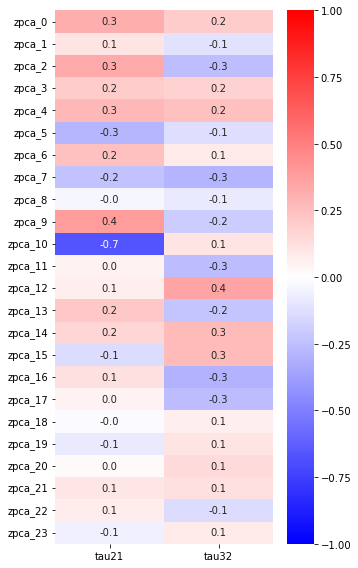

In [54]:
corrmat = pd.concat([df_pca_l1_bkg, df_tauratio_bkg], axis=1).corr().loc[df_pca_l1_bkg.columns, df_tauratio_bkg.columns]
plt.figure(figsize=(5,8))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()

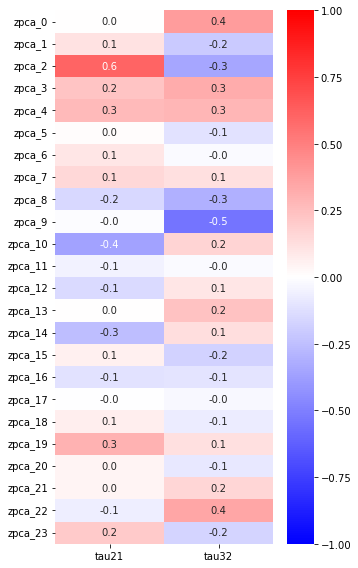

In [55]:
corrmat = pd.concat([df_pca_l1_sig, df_tauratio_sig], axis=1).corr().loc[df_pca_l1_sig.columns, df_tauratio_sig.columns]
plt.figure(figsize=(5,8))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()

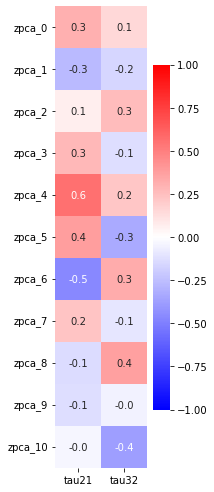

In [59]:
corrmat = pd.concat([df_pca_l2_bkg, df_tauratio_bkg], axis=1).corr().loc[df_pca_l2_bkg.columns, df_tauratio_bkg.columns]
plt.figure(figsize=(3,7))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()

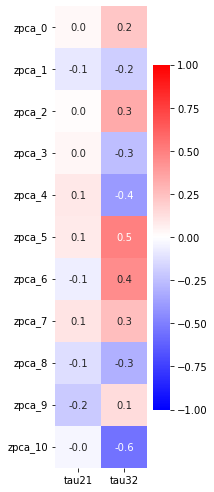

In [62]:
corrmat = pd.concat([df_pca_l2_sig, df_tauratio_sig], axis=1).corr().loc[df_pca_l2_sig.columns, df_tauratio_bkg.columns]
plt.figure(figsize=(3,7))
sns.heatmap(corrmat, annot = True, cmap='bwr', fmt='.1f',vmin= -1., vmax = 1.)
plt.tight_layout()